In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import gaussian_kde

In [11]:
df=pd.read_csv("/content/data.csv",encoding="latin1")

/tmp/ipython-input-252336948.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/data.csv",encoding="latin1")


In [12]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [13]:
x=pd.to_numeric(df["no2"],errors="coerce")
x=x.dropna()
x=x[x>=0]

In [14]:
x=x.to_numpy()
x.shape

(419509,)

In [15]:
r=102317229

In [16]:
a=0.5*(r%7)
b=0.3*((r%5)+1)

In [17]:
z=x+a*np.sin(b*x)

z=z.reshape(-1,1)
real=torch.tensor(z,dtype=torch.float32)

In [18]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        return self.net(x)

In [19]:
class Disc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(1,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.net(x)

In [21]:
g=Gen()
d=Disc()

loss=nn.BCELoss()

g_opt=optim.Adam(g.parameters(),lr=0.0002,betas=(0.5,0.999))
d_opt=optim.Adam(d.parameters(),lr=0.0002,betas=(0.5,0.999))

epochs=5000
bs=128

In [22]:
for e in range(epochs):
    idx=np.random.randint(0,len(real),bs)
    r_batch=real[idx]

    noise=torch.randn(bs,1)
    f_batch=g(noise)

    r_lbl=torch.ones(bs,1)
    f_lbl=torch.zeros(bs,1)

    d_real=d(r_batch)
    d_fake=d(f_batch.detach())

    d_loss_r=loss(d_real,r_lbl)
    d_loss_f=loss(d_fake,f_lbl)

    d_loss=d_loss_r+d_loss_f

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    out=d(f_batch)
    g_loss=loss(out,r_lbl)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if e%500==0:
        print(e,d_loss.item(),g_loss.item())

0 4.176328659057617 0.7271282076835632
500 1.356907606124878 0.8300260901451111
1000 1.3840686082839966 0.7194229364395142
1500 1.367116928100586 0.7481616139411926
2000 1.3580676317214966 0.6863858103752136
2500 1.371875286102295 0.6922457218170166
3000 1.3831040859222412 0.6851047277450562
3500 1.4013848304748535 0.652290940284729
4000 1.3776569366455078 0.6494163870811462
4500 1.3948755264282227 0.6529709696769714


In [23]:
with torch.no_grad():
    noise=torch.randn(10000,1)
    gen_z=g(noise).numpy().flatten()

In [24]:
kde=gaussian_kde(gen_z)

axis=np.linspace(gen_z.min(),gen_z.max(),1000)
pdf=kde(axis)

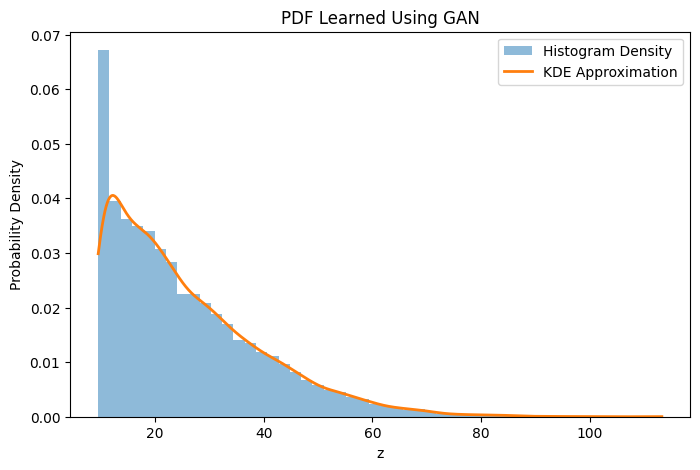

In [25]:
plt.figure(figsize=(8,5))
plt.hist(gen_z,bins=50,density=True,alpha=0.5,label="Histogram Density")
plt.plot(axis,pdf,linewidth=2,label="KDE Approximation")
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("PDF Learned Using GAN")
plt.legend()
plt.show()

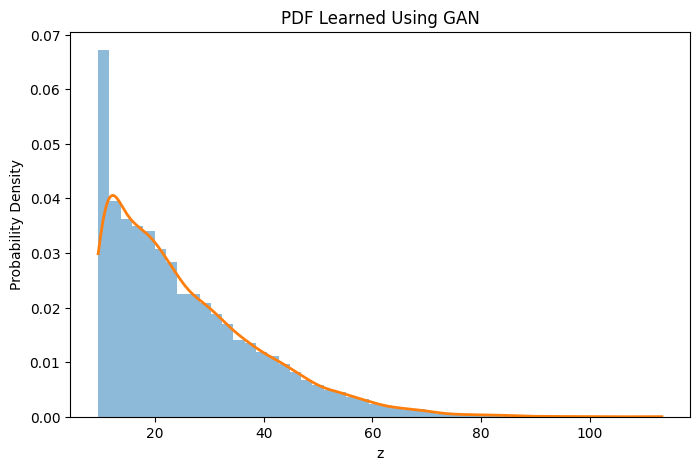

In [26]:
plt.figure(figsize=(8,5))
plt.hist(gen_z,bins=50,density=True,alpha=0.5)
plt.plot(axis,pdf,linewidth=2)
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("PDF Learned Using GAN")
plt.savefig("gan_pdf_plot.png",dpi=300,bbox_inches="tight")
plt.show()